In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
def generate_category_mappings(df):
    disease_categories = sorted(df['disease_type'].unique())
    disease_plant_categories = sorted((df['plant_type'] + " " + df['disease_type']).unique())

    # Disease mappings
    disease_name_to_num = {element: index for index, element in enumerate(disease_categories)}
    disease_num_to_name = {index: element for index, element in enumerate(disease_categories)}

    # Disease and Plant combined mappings
    disease_plant_name_to_num = {element: index for index, element in enumerate(disease_plant_categories)}
    disease_plant_num_to_name = {index: element for index, element in enumerate(disease_plant_categories)}

    # Healthy or not healthy mapping
    health_status = df['disease_type'].apply(lambda x: 'healthy' if x == 'healthy' else 'not healthy').unique()
    health_status = sorted(health_status)

    health_status_name_to_num = {status: idx for idx, status in enumerate(health_status)}
    health_status_num_to_name = {idx: status for idx, status in enumerate(health_status)}

    return {
        "disease_name_to_num": disease_name_to_num,
        "disease_num_to_name": disease_num_to_name,
        "disease_plant_name_to_num": disease_plant_name_to_num,
        "disease_plant_num_to_name": disease_plant_num_to_name,
        "health_status_name_to_num": health_status_name_to_num,
        "health_status_num_to_name": health_status_num_to_name
    }

# Note: generates many types of mapping for if we want to experiment with predicting
# different types of categories (eg. only disease, disease + plant, only healthy or not)
train_df = pd.read_csv('../dataset/dataset_metadata/train_set.csv')
test_df = pd.read_csv('../dataset/dataset_metadata/test_set.csv')
cat_mappings = generate_category_mappings(train_df)

In [4]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [5]:
# Initialize MLP
input_dim = 768
hidden_dim = 256
num_categories = len(cat_mappings["disease_name_to_num"])

model = SimpleMLP(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=num_categories)
criterion = nn.CrossEntropyLoss()

In [6]:
# Initialize Datasets and Dataloaders
train_embeddings = torch.load("../dataset/img_embeddings/train_img_embeddings.pt")
test_embeddings = torch.load("../dataset/img_embeddings/test_img_embeddings.pt")

train_categories = train_df['disease_type'].apply(lambda x: cat_mappings['disease_name_to_num'][x])
test_categories = test_df['disease_type'].apply(lambda x: cat_mappings['disease_name_to_num'][x])

train_dataset = TensorDataset(train_embeddings, torch.tensor(train_categories.values, dtype=torch.int64))
test_dataset = TensorDataset(test_embeddings, torch.tensor(test_categories.values, dtype=torch.int64))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

/scratch/997965/ipykernel_798189/2839997723.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_embeddings = torch.load("../dataset/img_embeddings/train_img_embeddings

In [26]:
# Training Loop

# Hyperparameters
num_epochs = 50
eval_interval = 2
lr = 0.001

optimizer = optim.Adam(model.parameters(), lr=lr)
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct = 0.0, 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
    
    train_loss /= len(train_loader.dataset)
    train_accuracy = train_correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    if (epoch + 1) % eval_interval == 0:
        model.eval()
        test_loss, test_correct = 0.0, 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                test_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                test_correct += (preds == labels).sum().item()
        
        test_loss /= len(test_loader.dataset)
        test_accuracy = test_correct / len(test_loader.dataset)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
              f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}')

Epoch [2/50], Train Loss: 0.0942, Train Acc: 0.9681, Test Loss: 0.0999, Test Acc: 0.9659
Epoch [4/50], Train Loss: 0.0474, Train Acc: 0.9836, Test Loss: 0.0736, Test Acc: 0.9728
Epoch [6/50], Train Loss: 0.0292, Train Acc: 0.9901, Test Loss: 0.0707, Test Acc: 0.9737
Epoch [8/50], Train Loss: 0.0237, Train Acc: 0.9919, Test Loss: 0.0791, Test Acc: 0.9714
Epoch [10/50], Train Loss: 0.0114, Train Acc: 0.9965, Test Loss: 0.0539, Test Acc: 0.9843
Epoch [12/50], Train Loss: 0.0142, Train Acc: 0.9954, Test Loss: 0.0518, Test Acc: 0.9839
Epoch [14/50], Train Loss: 0.0057, Train Acc: 0.9986, Test Loss: 0.0455, Test Acc: 0.9866
Epoch [16/50], Train Loss: 0.0173, Train Acc: 0.9947, Test Loss: 0.1226, Test Acc: 0.9627
Epoch [18/50], Train Loss: 0.0262, Train Acc: 0.9920, Test Loss: 0.1661, Test Acc: 0.9581
Epoch [20/50], Train Loss: 0.0132, Train Acc: 0.9959, Test Loss: 0.0595, Test Acc: 0.9816
Epoch [22/50], Train Loss: 0.0151, Train Acc: 0.9959, Test Loss: 0.0587, Test Acc: 0.9816
Epoch [24/50],

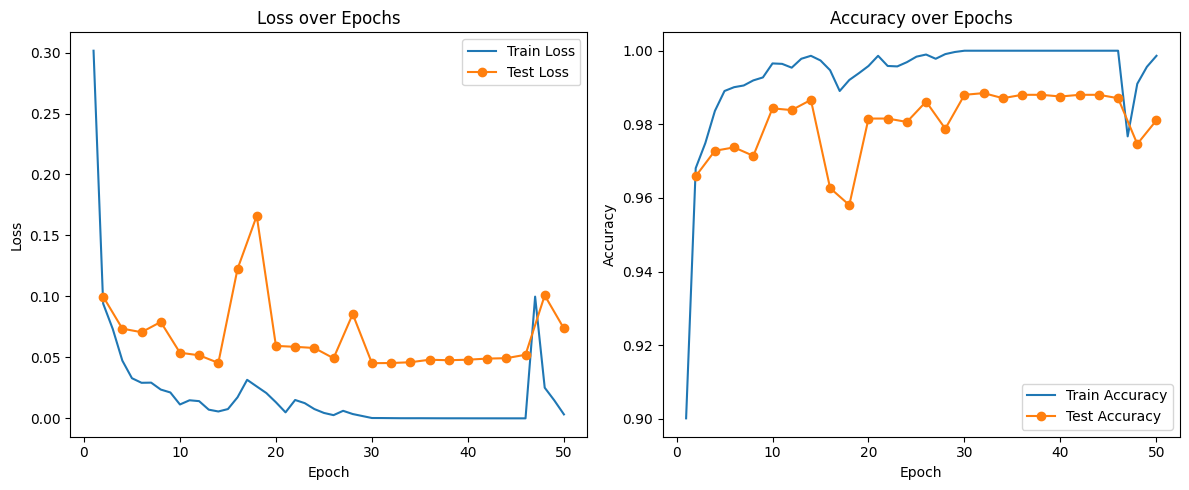

In [27]:
# Plotting accuracy and loss
epochs = range(1, num_epochs + 1)
eval_epochs = range(eval_interval, num_epochs + 1, eval_interval)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(eval_epochs, test_losses, label='Test Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(eval_epochs, test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [29]:
# Save Checkpoint

def save_checkpoint(model, optimizer, filepath):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved at '{filepath}'")

save_checkpoint(model, optimizer, '../mlp_checkpoint.pth')

Checkpoint saved at '../mlp_checkpoint.pth'


### Inference with Trained Model

Test Trained Model on Random Test Data 

In [7]:
from PIL import Image
import random
import os
from torchvision import transforms as T

input_dim = 768
hidden_dim = 256
num_categories = len(cat_mappings["disease_name_to_num"])

model = SimpleMLP(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=num_categories)
model.load_state_dict(torch.load('../mlp_checkpoint.pth')['model_state_dict'])
model.eval()

dinov2_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')
dinov2_model.eval()

test_df = pd.read_csv('../dataset/dataset_metadata/test_set.csv')

# Same function as from embedding_extraction.ipynb
def dinov2_preprocess(H, W):
    patch_size = 14
    new_H = H - H % patch_size
    new_W = W - W % patch_size
    transform = T.Compose([
        T.Resize((new_H, new_W), interpolation=T.InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])

    return transform

def inference(img, model, dinov2_model, cat_mappings):
    W, H = img.size[0], img.size[1]
    transform = dinov2_preprocess(H, W)
    input_tensor = transform(img)
    embedding = dinov2_model(input_tensor.unsqueeze(0))

    mlp_output = model(embedding)
    mlp_output = torch.argmax(mlp_output).item()
    
    disease_name = cat_mappings['disease_num_to_name'][mlp_output]

    return disease_name

/scratch/997965/ipykernel_798189/399929479.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../mlp_checkpoint.pth')['model_state_dict']

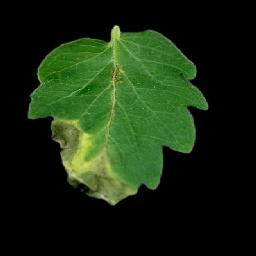

Actual Disease Name: blight
Predicted Disease Name: blight


In [61]:
idx = random.randint(0, len(test_df))
category = test_df.iloc[idx]['category']
filename = test_df.iloc[idx]['filename']

img_path = os.path.join('../dataset/raw', category, filename)
image = Image.open(img_path).convert('RGB')

pred_disease_name = inference(image, model, dinov2_model, cat_mappings)
actual_disease_name = test_df.iloc[idx]['disease_type']

display(image)
print(f'Actual Disease Name: {actual_disease_name}')
print(f'Predicted Disease Name: {pred_disease_name}')

### Evaluation Metrics 

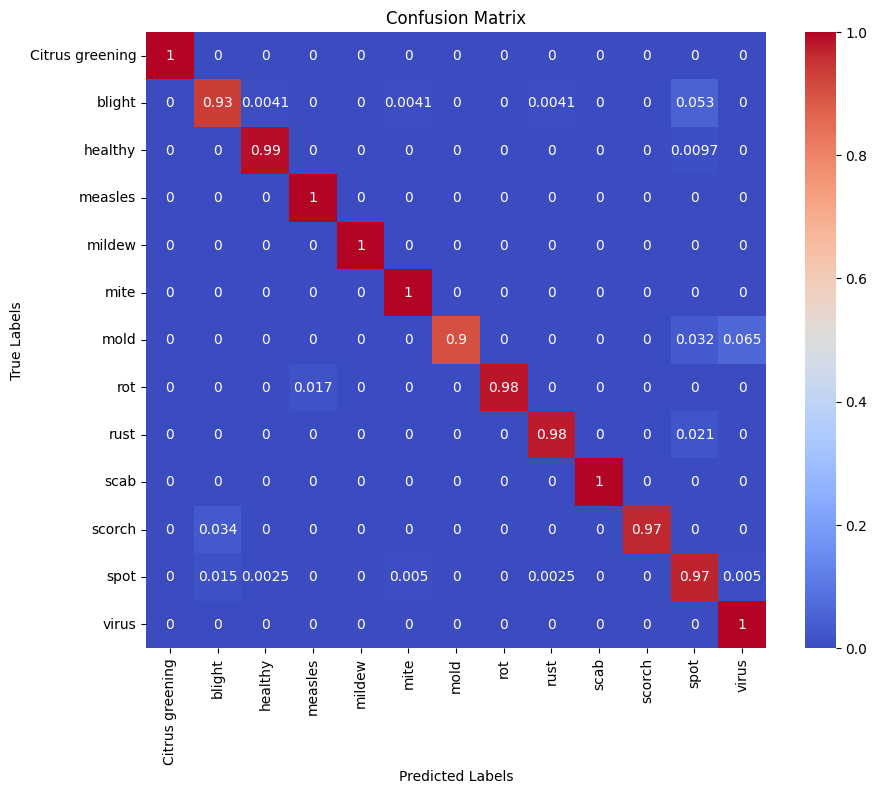

F1 Scores per Category
    Citrus greening: 1.000
    blight: 0.950
    healthy: 0.994
    measles: 0.991
    mildew: 1.000
    mite: 0.980
    mold: 0.949
    rot: 0.991
    rust: 0.969
    scab: 1.000
    scorch: 0.983
    spot: 0.959
    virus: 0.991


In [18]:
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns

def generate_confusion_matrix(model, test_loader, class_names):
    model.eval()
    
    pred_labels = []
    gt_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            pred_labels.extend(preds.cpu().numpy())
            gt_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(gt_labels, pred_labels, normalize='true')

    f1 = f1_score(gt_labels, pred_labels, average=None)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, cmap='coolwarm', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    return f1

disease_num_to_name = cat_mappings['disease_num_to_name']
disease_names = [name for _, name in sorted(disease_num_to_name.items())]
f1 = generate_confusion_matrix(model, test_loader, disease_names)

print('F1 Scores per Category')
for i, name in enumerate(disease_names):
    print(f'    {name}: {f1[i]:.3f}')
